In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [140]:
def plot_scaling(csv_path, filter_map, show_speedup=True, save=False, filename=None):
    """
    Plot execution time or speedup vs number of threads,
    filtered by executable(s) and input file(s).
    
    Args:
        csv_path (str): Path to the CSV file.
        filter_map (dict): Dictionary {column -> list_of_values} for filtering the dataset.
            Example: {
                'Num Threads': [1, 2, 4, 8],
                'Input File': ['file1.txt', 'file2.txt'],
                'Executable': ['prog1.exe', 'prog2.exe']
            }
        show_speedup (bool): If True, plot speedup instead of execution time.
        save (bool): If True, save the plot under ../plots/ instead of (or in addition to) showing it.
    """
    # Load CSV
    df = pd.read_csv(csv_path)
    
    # Strip whitespace from strings
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    
    # Ensure thread count is integer
    df['Num Threads'] = df['Num Threads'].astype(int)
    
    # Apply filters
    for col, values in filter_map.items():
        df = df[df[col].isin(values)]
    
    if df.empty:
        print("Warning: no rows match the provided filters!")
        return
    
    plt.figure(figsize=(10, 6))
    
    # Iterate over each executable and input file
    for exe in df['Executable'].unique():
        for file in df['Input File'].unique():
            subset = df[(df['Executable'] == exe) & (df['Input File'] == file)]
            subset = subset.sort_values('Num Threads')
            
            x = subset['Num Threads']
            y = subset['Execution Time (ms)']
            
            if show_speedup:
                baseline = y.iloc[0]
                y = baseline / y
            
            label = f"{exe} - {file}"
            plt.plot(x, y, marker='o', label=label)
    
    # Force all available thread counts as x-axis ticks
    all_threads = sorted(df['Num Threads'].unique())
    plt.xticks(all_threads)
    
    plt.xlabel("Number of Threads")
    plt.ylabel("Speedup" if show_speedup else "Execution Time (ms)")
    plt.title("Performance Plot" + (" (Speedup)" if show_speedup else " (Execution Time)"))
    plt.legend()
    plt.grid(True)
    
    if save:
        # Create ../plots folder if it does not exist
        output_dir = os.path.join(os.path.dirname(csv_path), "..", "plots")
        os.makedirs(output_dir, exist_ok=True)
        
        # Choose filename based on mode
        mode = "speedup" if show_speedup else "execution_time"
        filename = f"{mode}_plot.png" if filename is None else filename
        filepath = os.path.join(output_dir, filename)
        
        plt.savefig(filepath, bbox_inches="tight")
        print(f"Plot saved to {filepath}")
    else:
        plt.show()

Plot saved to ../tables\..\plots\exec_time_DTF_vanilla_small.png


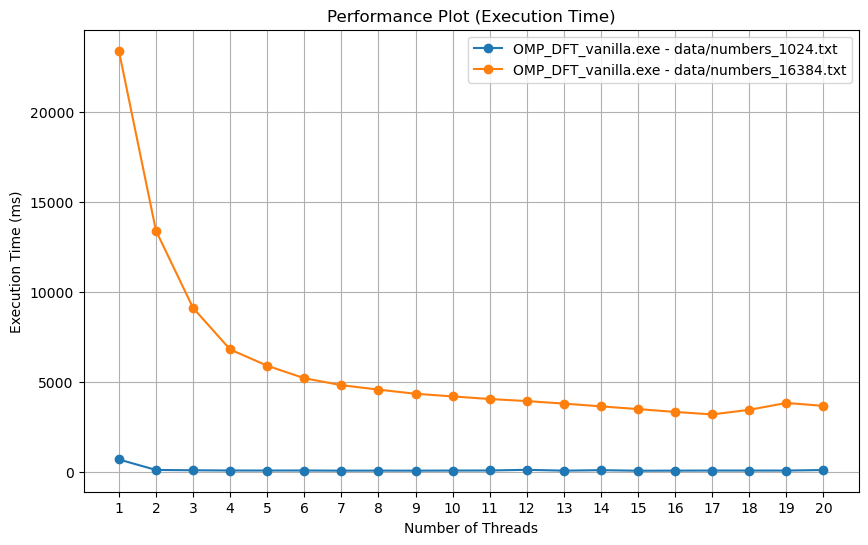

In [141]:
plot_scaling(
    "../tables/CPU_mean.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['data/numbers_1024.txt','data/numbers_16384.txt'],
        'Executable': ['OMP_DFT_vanilla.exe']
    },
    show_speedup=False,
    save=True,
    filename="exec_time_DTF_vanilla_small.png"
)

Plot saved to ../tables\..\plots\exec_time_DTF_vanilla_large.png


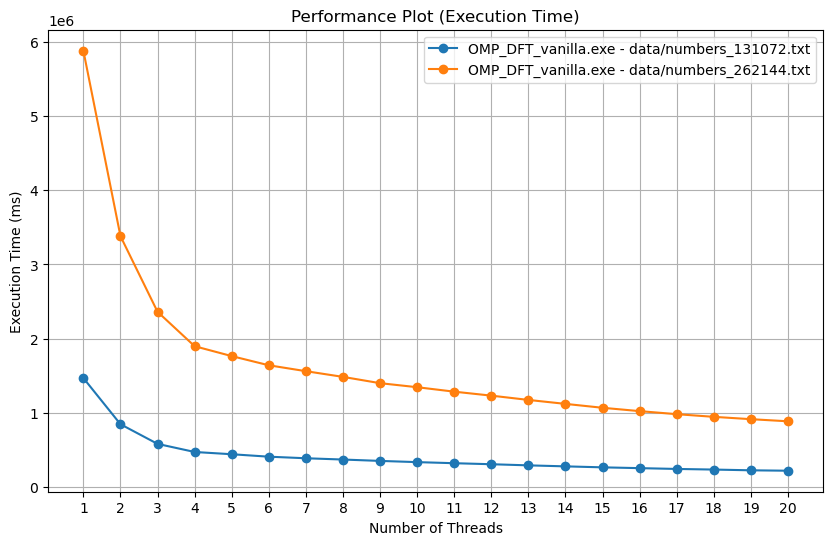

In [142]:
plot_scaling(
    "../tables/CPU_mean.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['data/numbers_131072.txt', 'data/numbers_262144.txt'],
        'Executable': ['OMP_DFT_vanilla.exe']
    },
    show_speedup=False,
    save=True,
    filename="exec_time_DTF_vanilla_large.png"
)

Plot saved to ../tables\..\plots\speedup_DTF_vanilla.png


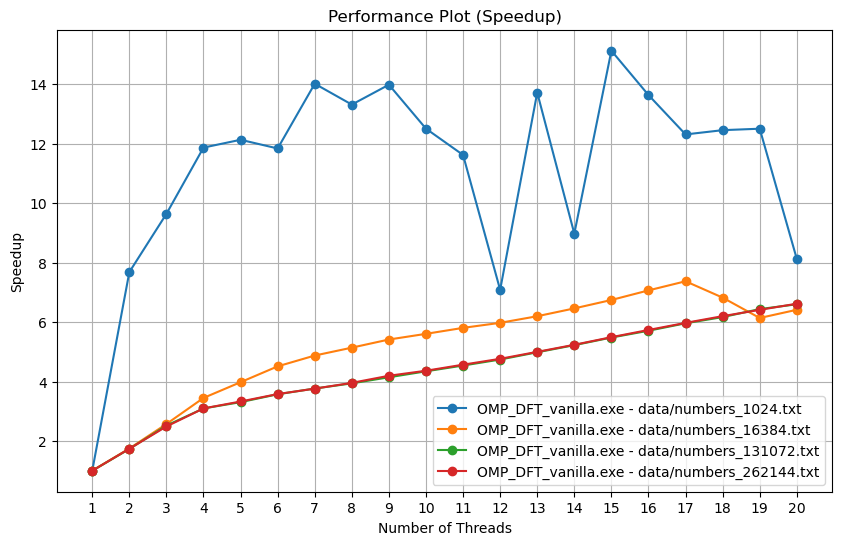

In [143]:
plot_scaling(
    "../tables/CPU_mean.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['data/numbers_1024.txt','data/numbers_16384.txt', 'data/numbers_131072.txt', 'data/numbers_262144.txt'],
        'Executable': ['OMP_DFT_vanilla.exe']
    },
    show_speedup=True,
    save=True,
    filename="speedup_DTF_vanilla.png"
)

Plot saved to ../tables\..\plots\exec_time_DTF_optimized_small.png


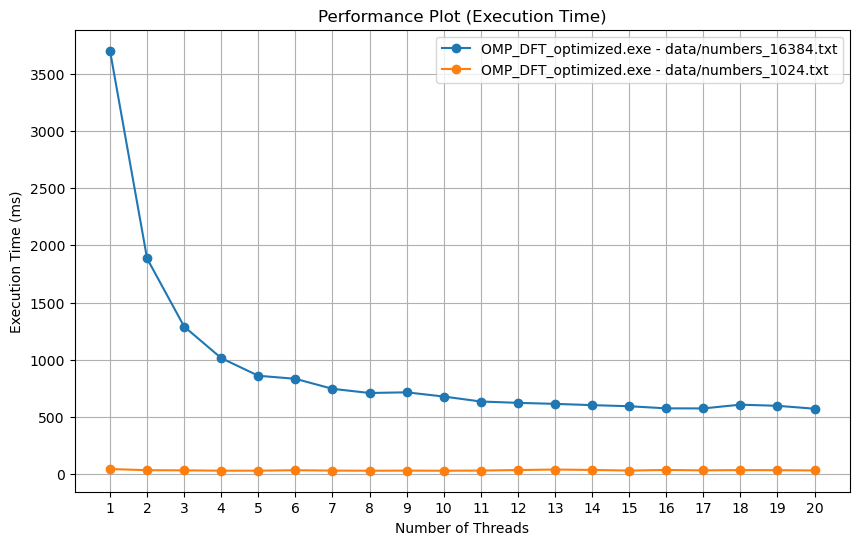

In [144]:
plot_scaling(
    "../tables/CPU_mean.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['data/numbers_1024.txt','data/numbers_16384.txt'],
        'Executable': ['OMP_DFT_optimized.exe']
    },
    show_speedup=False,
    save=True,
    filename="exec_time_DTF_optimized_small.png"
)

Plot saved to ../tables\..\plots\exec_time_DTF_optimized_large.png


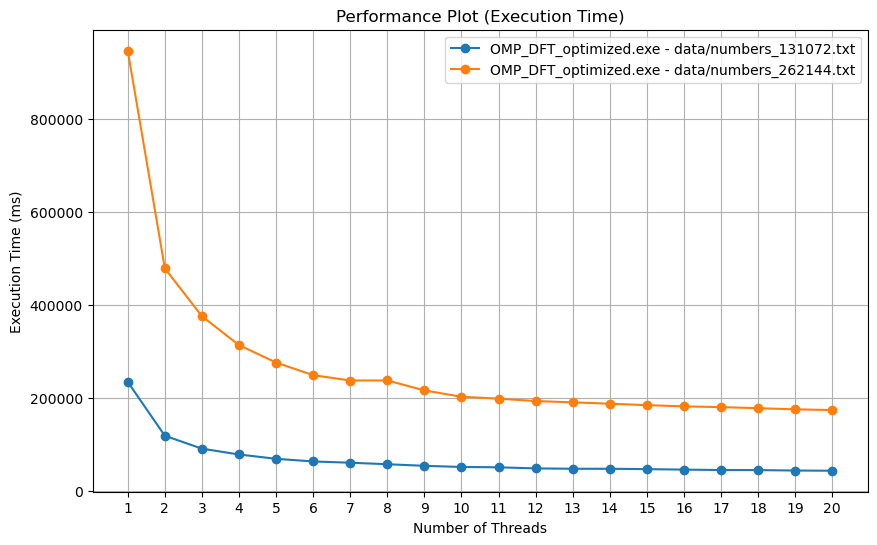

In [145]:
plot_scaling(
    "../tables/CPU_mean.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['data/numbers_131072.txt', 'data/numbers_262144.txt'],
        'Executable': ['OMP_DFT_optimized.exe']
    },
    show_speedup=False,
    save=True,
    filename="exec_time_DTF_optimized_large.png"
)

Plot saved to ../tables\..\plots\speedup_DTF_optimized.png


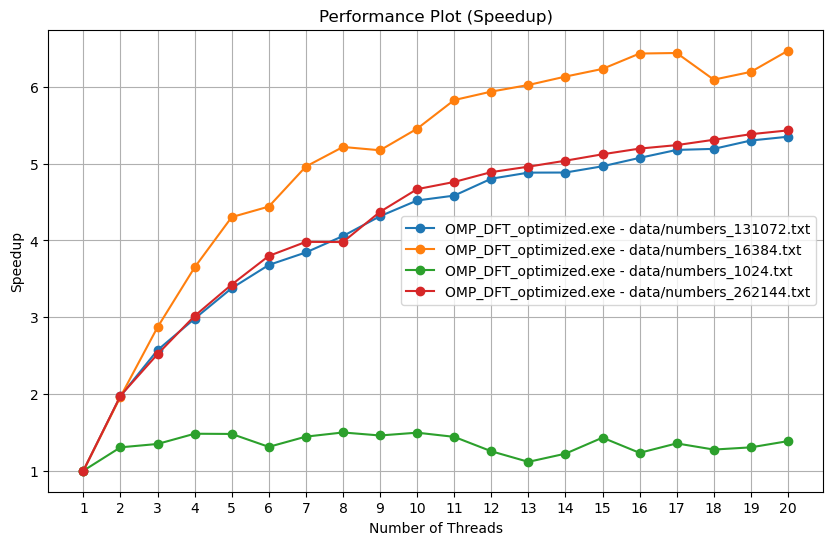

In [146]:
plot_scaling(
    "../tables/CPU_mean.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['data/numbers_1024.txt','data/numbers_16384.txt', 'data/numbers_131072.txt', 'data/numbers_262144.txt'],
        'Executable': ['OMP_DFT_optimized.exe']
    },
    show_speedup=True,
    save=True,
    filename="speedup_DTF_optimized.png"
)

Plot saved to ../tables\..\plots\exec_time_FFT.png


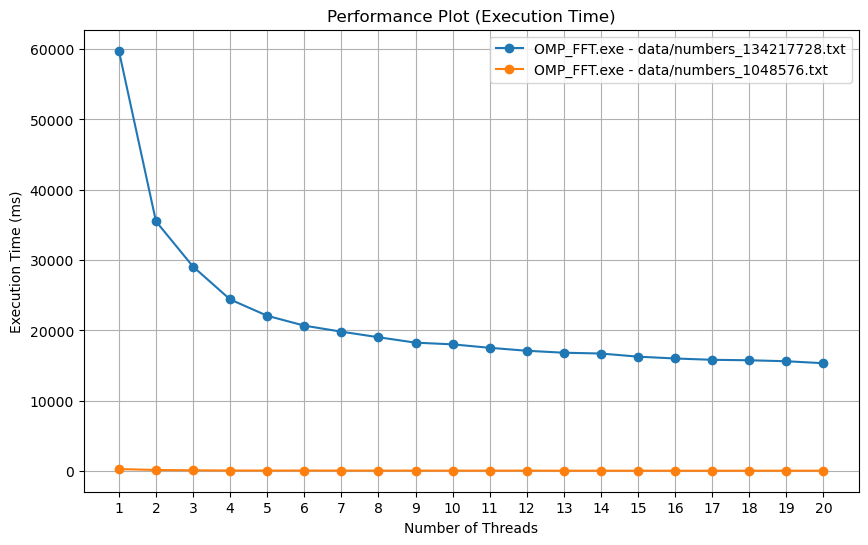

In [147]:
plot_scaling(
    "../tables/CPU_mean.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['data/numbers_1048576.txt','data/numbers_134217728.txt'],
        'Executable': ['OMP_FFT.exe']
    },
    show_speedup=False,
    save=True,
    filename="exec_time_FFT.png"
)

Plot saved to ../tables\..\plots\speedup_FFT.png


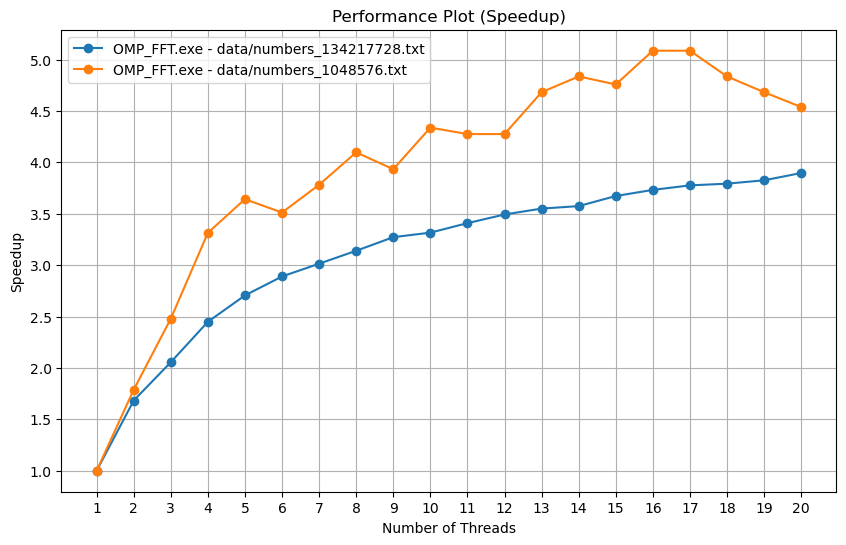

In [148]:
plot_scaling(
    "../tables/CPU_mean.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['data/numbers_1048576.txt','data/numbers_134217728.txt'],
        'Executable': ['OMP_FFT.exe']
    },
    show_speedup=True,
    save=True,
    filename="speedup_FFT.png"
)